In [4]:
import pandas as pd
from chembl_webresource_client.new_client import new_client

# Set up the ChEMBL client
chembl_client = new_client


In [5]:
def smiles_to_chembl_id(smiles):
    try:
        molecule = chembl_client.molecule
        result = molecule.filter(smiles=smiles).only("chembl_id")
        return result[0]["chembl_id"] if result else None
    except Exception as e:
        print(f"Error converting SMILES to ChEMBL ID for {smiles}: {e}")
        return None


In [6]:
def get_bioactivities_for_chembl_id(chembl_id):
    try:
        # Verify the molecule exists with the given ChEMBL ID
        molecule = chembl_client.molecule
        compound_info_list = list(molecule.filter(molecule_chembl_id=chembl_id).only("molecule_chembl_id"))
        
        if not compound_info_list:
            print(f"ChEMBL ID {chembl_id} not found in the database.")
            return None

        # Fetch bioactivity data associated with the molecule
        desired_types = ["IC50", "EC50", "AC50", "GI50", "Ki"]
        bioactivities = chembl_client.activity.filter(
            molecule_chembl_id=chembl_id,
            target_type="SINGLE PROTEIN", 
            target_organism = "Homo sapiens",
            type__in=desired_types
        )

        bioactivities_list = list(bioactivities)
        
        # Fetch gene names for the targets and augment the bioactivity records
        for activity in bioactivities_list:
            
            target_id = activity["target_chembl_id"]
            target_data = chembl_client.target.filter(target_chembl_id=target_id).only("target_components")
            
            if target_data and target_data[0].get("target_components"):
                # Assuming the first component is the primary gene; modify as needed
                gene_symbol = next((synonym['component_synonym'] 
                   for synonym in target_data[0]['target_components'][0]['target_component_synonyms'] 
                   if synonym['syn_type'] == 'GENE_SYMBOL'), None)
                
                activity["gene_symbol"] = gene_symbol
            else:
                activity["gene_symbol"] = None
        return bioactivities_list
        
    except Exception as e:
        print(f"Error retrieving targets for ChEMBL ID {chembl_id}: {e}")
        return None

In [7]:
bray = pd.read_csv("Bray_compounds_processed_chembl_identifiers.csv.gz", compression="gzip")
bray = bray[bray.ChEMBL_ID.notna()].reset_index(drop=True)
bray

,InChICode_standardised,Standardized_SMILES_chembl,Standardized_InChI_chembl,Standardized_InChIKey_chembl,ChEMBL_ID
0,InChI=1S/C12H15N3O2S/c1-7(2)18-8-4-5-9-10(6-8)...,COC(=O)Nc1nc2ccc(SC(C)C)cc2[nH]1,InChI=1S/C12H15N3O2S/c1-7(2)18-8-4-5-9-10(6-8)...,SXJIZQPZESTWLD-UHFFFAOYSA-N,CHEMBL1354363
1,InChI=1S/C12H18N4O3/c1-7(2)5-16-10-9(11(17)15(...,COCc1nc2c(=O)n(C)c(=O)n(CC(C)C)c2[nH]1,InChI=1S/C12H18N4O3/c1-7(2)5-16-10-9(11(17)15(...,NBLBCGUCPBXKOV-UHFFFAOYSA-N,CHEMBL307639
2,InChI=1S/C16H29N5O3/c1-12-9-20(13(2)10-22)16(2...,CNC[C@@H]1OCc2cnnn2CCCC(=O)N([C@H](C)CO)C[C@H]1C,InChI=1S/C16H29N5O3/c1-12-9-20(13(2)10-22)16(2...,FOLOUAULJSJVDY-NFAWXSAZSA-N,CHEMBL3187280
3,InChI=1S/C17H13NO3/c1-18-13-5-3-2-4-12(13)15(1...,Cn1c(-c2ccc3c(c2)OCO3)cc(=O)c2ccccc21,InChI=1S/C17H13NO3/c1-18-13-5-3-2-4-12(13)15(1...,COBBNRKBTCBWQP-UHFFFAOYSA-N,CHEMBL1371756
4,InChI=1S/C17H31N5O5S/c1-13-8-22(14(2)11-23)17(...,C[C@H]1CN([C@@H](C)CO)C(=O)CCCn2cc(nn2)CO[C@@H...,InChI=1S/C17H31N5O5S/c1-13-8-22(14(2)11-23)17(...,PUHFBKBPROGAIN-OFQRWUPVSA-N,CHEMBL1890625
...,...,...,...,...,...
12447,InChI=1S/C9H9N5OS2/c10-12-8(16)11-6-3-1-2-5(4-...,NNC(S)=Nc1cccc(-c2nnc(S)o2)c1,InChI=1S/C9H9N5OS2/c10-12-8(16)11-6-3-1-2-5(4-...,LHXWPDUWZAYBJV-UHFFFAOYSA-N,CHEMBL1432353
12448,InChI=1S/C9H9NO/c11-6-7-5-10-9-4-2-1-3-8(7)9/h...,OCc1c[nH]c2ccccc12,InChI=1S/C9H9NO/c11-6-7-5-10-9-4-2-1-3-8(7)9/h...,IVYPNXXAYMYVSP-UHFFFAOYSA-N,CHEMBL155625
12449,InChI=1S/C9H9NO2/c10-8-3-1-2-7(6-8)4-5-9(11)12...,Nc1cccc(/C=C/C(=O)O)c1,InChI=1S/C9H9NO2/c10-8-3-1-2-7(6-8)4-5-9(11)12...,JNXMJSYJCFTLJB-SNAWJCMRSA-N,CHEMBL1379670
12450,InChI=1S/C9H9NO3S/c1-6(11)5-14-8-3-2-7(4-10-8)...,CC(=O)CSc1ccc(C(=O)O)cn1,InChI=1S/C9H9NO3S/c1-6(11)5-14-8-3-2-7(4-10-8)...,LRBIKSYRCFHKBN-UHFFFAOYSA-N,CHEMBL1305263


In [12]:
bray.ChEMBL_ID.nunique()


12452

In [13]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True, nb_workers=80)

# List of ChEMBL IDs
chembl_ids = bray.ChEMBL_ID.unique()[:]


# Use parallel_apply to retrieve data for each ChEMBL ID in parallel
dfs = pd.Series(chembl_ids).parallel_apply(get_bioactivities_for_chembl_id)


INFO: Pandarallel will run on 80 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [14]:
# Convert each list of dictionaries in dfs to a DataFrame
dfs_list = [pd.DataFrame(data_dict) for data_dict in dfs]

# Concatenate all the DataFrames
final_df = pd.concat(dfs_list, ignore_index=True)
final_df

/tmp/ipykernel_8861/3415553419.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat(dfs_list, ignore_index=True)


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value,gene_symbol
0,None,inactive,5997753,[],CHEMBL1741325,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,None,None,BAO_0000186,...,Cytochrome P450 2C9,9606,None,None,AC50,None,None,None,None,CYP2C9
1,None,Active,6003131,[],CHEMBL1741322,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,None,None,BAO_0000186,...,Cytochrome P450 1A2,9606,None,None,AC50,uM,UO_0000065,None,0.501187234,CYP1A2
2,None,inconclusive,6004045,[],CHEMBL1741323,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,None,None,BAO_0000186,...,Cytochrome P450 2C19,9606,None,None,AC50,uM,UO_0000065,None,10.0,CYP2C19
3,None,inactive,6005576,[],CHEMBL1741324,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,None,None,BAO_0000186,...,Cytochrome P450 3A4,9606,None,None,AC50,None,None,None,None,CYP3A4
4,None,inactive,6037739,[],CHEMBL1741321,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,None,None,BAO_0000186,...,Cytochrome P450 2D6,9606,None,None,AC50,None,None,None,None,CYP2D6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166819,None,inactive,6027814,[],CHEMBL1741324,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,None,None,BAO_0000186,...,Cytochrome P450 3A4,9606,None,None,AC50,None,None,None,None,CYP3A4
166820,None,inactive,6031193,[],CHEMBL1741323,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,None,None,BAO_0000186,...,Cytochrome P450 2C19,9606,None,None,AC50,None,None,None,None,CYP2C19
166821,None,inactive,6071881,[],CHEMBL1741321,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,None,None,BAO_0000186,...,Cytochrome P450 2D6,9606,None,None,AC50,None,None,None,None,CYP2D6
166822,None,None,18028747,[],CHEMBL4007134,Cytotoxicity against human U251 cells assessed...,F,None,None,BAO_0000188,...,U-251,9606,None,None,EC50,uM,UO_0000065,None,390.0,None


In [15]:
final_df = final_df[final_df.gene_symbol.notna()]
mask = ~final_df['assay_description'].str.lower().str.contains('mutant|recombinant')
final_df = final_df[mask].sort_values("type").reset_index(drop=True)
final_df

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value,gene_symbol
0,None,inactive,5997753,[],CHEMBL1741325,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,None,None,BAO_0000186,...,Cytochrome P450 2C9,9606,None,None,AC50,None,None,None,None,CYP2C9
1,None,inactive,6014444,[],CHEMBL1741324,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,None,None,BAO_0000186,...,Cytochrome P450 3A4,9606,None,None,AC50,None,None,None,None,CYP3A4
2,None,inactive,6017729,[],CHEMBL1741323,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,None,None,BAO_0000186,...,Cytochrome P450 2C19,9606,None,None,AC50,None,None,None,None,CYP2C19
3,None,Active,6034052,[],CHEMBL1741322,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,None,None,BAO_0000186,...,Cytochrome P450 1A2,9606,None,None,AC50,uM,UO_0000065,None,15.84893192,CYP1A2
4,None,Active,6062928,[],CHEMBL1741321,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,None,None,BAO_0000186,...,Cytochrome P450 2D6,9606,None,None,AC50,uM,UO_0000065,None,0.063095734,CYP2D6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135003,None,Not Active (inhibition < 50% @ 10 uM and thus ...,7785483,[],CHEMBL1909128,DRUGMATRIX: Chemokine CXCR2 (IL-8B) radioligan...,B,None,None,BAO_0000192,...,Interleukin-8 receptor B,9606,None,None,Ki,None,None,None,None,CXCR2
135004,None,Not Active (inhibition < 50% @ 10 uM and thus ...,7819870,[],CHEMBL1909207,"DRUGMATRIX: Protein Tyrosine Phosphatase, PTPR...",B,None,None,BAO_0000192,...,Leukocyte common antigen,9606,None,None,Ki,None,None,None,None,PTPRC
135005,None,Not Active (inhibition < 50% @ 10 uM and thus ...,7785485,[],CHEMBL1909129,DRUGMATRIX: Cholecystokinin CCKA radioligand b...,B,None,None,BAO_0000192,...,Cholecystokinin A receptor,9606,None,None,Ki,None,None,None,None,CCKAR
135006,None,Not Active (inhibition < 50% @ 10 uM and thus ...,7764809,[],CHEMBL1909196,"DRUGMATRIX: Peptidase, Matrix Metalloprotease-...",B,None,None,BAO_0000192,...,Matrix metalloproteinase-1,9606,None,None,Ki,None,None,None,None,MMP1


In [16]:
final_df.parent_molecule_chembl_id.unique()

array(['CHEMBL1354363', 'CHEMBL294649', 'CHEMBL127508', ...,
       'CHEMBL59836', 'CHEMBL15150', 'CHEMBL17045'], dtype=object)

In [17]:
final_df.to_csv("Binding_activities_chembl_bray.csv.gz", index=False, compression='gzip')

In [18]:
import pandas as pd

In [19]:
final_df = pd.read_csv("Binding_activities_chembl_bray.csv.gz", compression='gzip', low_memory=False)
final_df

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value,gene_symbol
0,NaN,inactive,5997753,[],CHEMBL1741325,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,Cytochrome P450 2C9,9606,NaN,NaN,AC50,NaN,NaN,NaN,NaN,CYP2C9
1,NaN,inactive,6014444,[],CHEMBL1741324,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,Cytochrome P450 3A4,9606,NaN,NaN,AC50,NaN,NaN,NaN,NaN,CYP3A4
2,NaN,inactive,6017729,[],CHEMBL1741323,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,Cytochrome P450 2C19,9606,NaN,NaN,AC50,NaN,NaN,NaN,NaN,CYP2C19
3,NaN,Active,6034052,[],CHEMBL1741322,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,Cytochrome P450 1A2,9606,NaN,NaN,AC50,uM,UO_0000065,NaN,15.848932,CYP1A2
4,NaN,Active,6062928,[],CHEMBL1741321,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,Cytochrome P450 2D6,9606,NaN,NaN,AC50,uM,UO_0000065,NaN,0.063096,CYP2D6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135003,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7785483,[],CHEMBL1909128,DRUGMATRIX: Chemokine CXCR2 (IL-8B) radioligan...,B,NaN,NaN,BAO_0000192,...,Interleukin-8 receptor B,9606,NaN,NaN,Ki,NaN,NaN,NaN,NaN,CXCR2
135004,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7819870,[],CHEMBL1909207,"DRUGMATRIX: Protein Tyrosine Phosphatase, PTPR...",B,NaN,NaN,BAO_0000192,...,Leukocyte common antigen,9606,NaN,NaN,Ki,NaN,NaN,NaN,NaN,PTPRC
135005,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7785485,[],CHEMBL1909129,DRUGMATRIX: Cholecystokinin CCKA radioligand b...,B,NaN,NaN,BAO_0000192,...,Cholecystokinin A receptor,9606,NaN,NaN,Ki,NaN,NaN,NaN,NaN,CCKAR
135006,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7764809,[],CHEMBL1909196,"DRUGMATRIX: Peptidase, Matrix Metalloprotease-...",B,NaN,NaN,BAO_0000192,...,Matrix metalloproteinase-1,9606,NaN,NaN,Ki,NaN,NaN,NaN,NaN,MMP1


In [20]:
final_df.standard_relation.unique()

array([nan, '=', '>', '<', '<=', '>=', '>>', '~'], dtype=object)

In [21]:
final_df = final_df[~final_df["standard_relation"].isin(['>', '<', '~', '>=', '<=', '>>'])]
final_df

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value,gene_symbol
0,NaN,inactive,5997753,[],CHEMBL1741325,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,Cytochrome P450 2C9,9606,NaN,NaN,AC50,NaN,NaN,NaN,NaN,CYP2C9
1,NaN,inactive,6014444,[],CHEMBL1741324,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,Cytochrome P450 3A4,9606,NaN,NaN,AC50,NaN,NaN,NaN,NaN,CYP3A4
2,NaN,inactive,6017729,[],CHEMBL1741323,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,Cytochrome P450 2C19,9606,NaN,NaN,AC50,NaN,NaN,NaN,NaN,CYP2C19
3,NaN,Active,6034052,[],CHEMBL1741322,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,Cytochrome P450 1A2,9606,NaN,NaN,AC50,uM,UO_0000065,NaN,15.848932,CYP1A2
4,NaN,Active,6062928,[],CHEMBL1741321,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,Cytochrome P450 2D6,9606,NaN,NaN,AC50,uM,UO_0000065,NaN,0.063096,CYP2D6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135003,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7785483,[],CHEMBL1909128,DRUGMATRIX: Chemokine CXCR2 (IL-8B) radioligan...,B,NaN,NaN,BAO_0000192,...,Interleukin-8 receptor B,9606,NaN,NaN,Ki,NaN,NaN,NaN,NaN,CXCR2
135004,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7819870,[],CHEMBL1909207,"DRUGMATRIX: Protein Tyrosine Phosphatase, PTPR...",B,NaN,NaN,BAO_0000192,...,Leukocyte common antigen,9606,NaN,NaN,Ki,NaN,NaN,NaN,NaN,PTPRC
135005,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7785485,[],CHEMBL1909129,DRUGMATRIX: Cholecystokinin CCKA radioligand b...,B,NaN,NaN,BAO_0000192,...,Cholecystokinin A receptor,9606,NaN,NaN,Ki,NaN,NaN,NaN,NaN,CCKAR
135006,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7764809,[],CHEMBL1909196,"DRUGMATRIX: Peptidase, Matrix Metalloprotease-...",B,NaN,NaN,BAO_0000192,...,Matrix metalloproteinase-1,9606,NaN,NaN,Ki,NaN,NaN,NaN,NaN,MMP1


In [22]:
final_df = final_df[final_df["activity_comment"].str.lower()!="inconclusive"]
final_df

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value,gene_symbol
0,NaN,inactive,5997753,[],CHEMBL1741325,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,Cytochrome P450 2C9,9606,NaN,NaN,AC50,NaN,NaN,NaN,NaN,CYP2C9
1,NaN,inactive,6014444,[],CHEMBL1741324,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,Cytochrome P450 3A4,9606,NaN,NaN,AC50,NaN,NaN,NaN,NaN,CYP3A4
2,NaN,inactive,6017729,[],CHEMBL1741323,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,Cytochrome P450 2C19,9606,NaN,NaN,AC50,NaN,NaN,NaN,NaN,CYP2C19
3,NaN,Active,6034052,[],CHEMBL1741322,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,Cytochrome P450 1A2,9606,NaN,NaN,AC50,uM,UO_0000065,NaN,15.848932,CYP1A2
4,NaN,Active,6062928,[],CHEMBL1741321,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,Cytochrome P450 2D6,9606,NaN,NaN,AC50,uM,UO_0000065,NaN,0.063096,CYP2D6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135003,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7785483,[],CHEMBL1909128,DRUGMATRIX: Chemokine CXCR2 (IL-8B) radioligan...,B,NaN,NaN,BAO_0000192,...,Interleukin-8 receptor B,9606,NaN,NaN,Ki,NaN,NaN,NaN,NaN,CXCR2
135004,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7819870,[],CHEMBL1909207,"DRUGMATRIX: Protein Tyrosine Phosphatase, PTPR...",B,NaN,NaN,BAO_0000192,...,Leukocyte common antigen,9606,NaN,NaN,Ki,NaN,NaN,NaN,NaN,PTPRC
135005,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7785485,[],CHEMBL1909129,DRUGMATRIX: Cholecystokinin CCKA radioligand b...,B,NaN,NaN,BAO_0000192,...,Cholecystokinin A receptor,9606,NaN,NaN,Ki,NaN,NaN,NaN,NaN,CCKAR
135006,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7764809,[],CHEMBL1909196,"DRUGMATRIX: Peptidase, Matrix Metalloprotease-...",B,NaN,NaN,BAO_0000192,...,Matrix metalloproteinase-1,9606,NaN,NaN,Ki,NaN,NaN,NaN,NaN,MMP1


In [23]:
final_df = final_df[~final_df.standard_units.isin(['mg kg-1', 'ug.mL-1', 'uM tube-1', "10'3pM",
       '10^2 uM', 's-1', '10^-2/min', "10'5/M/min", 'Ratio', '10^-9/min',
       'ug ml-1', 'nM l-1 hr-1'])]
final_df

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value,gene_symbol
0,NaN,inactive,5997753,[],CHEMBL1741325,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,Cytochrome P450 2C9,9606,NaN,NaN,AC50,NaN,NaN,NaN,NaN,CYP2C9
1,NaN,inactive,6014444,[],CHEMBL1741324,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,Cytochrome P450 3A4,9606,NaN,NaN,AC50,NaN,NaN,NaN,NaN,CYP3A4
2,NaN,inactive,6017729,[],CHEMBL1741323,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,Cytochrome P450 2C19,9606,NaN,NaN,AC50,NaN,NaN,NaN,NaN,CYP2C19
3,NaN,Active,6034052,[],CHEMBL1741322,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,Cytochrome P450 1A2,9606,NaN,NaN,AC50,uM,UO_0000065,NaN,15.848932,CYP1A2
4,NaN,Active,6062928,[],CHEMBL1741321,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,Cytochrome P450 2D6,9606,NaN,NaN,AC50,uM,UO_0000065,NaN,0.063096,CYP2D6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135003,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7785483,[],CHEMBL1909128,DRUGMATRIX: Chemokine CXCR2 (IL-8B) radioligan...,B,NaN,NaN,BAO_0000192,...,Interleukin-8 receptor B,9606,NaN,NaN,Ki,NaN,NaN,NaN,NaN,CXCR2
135004,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7819870,[],CHEMBL1909207,"DRUGMATRIX: Protein Tyrosine Phosphatase, PTPR...",B,NaN,NaN,BAO_0000192,...,Leukocyte common antigen,9606,NaN,NaN,Ki,NaN,NaN,NaN,NaN,PTPRC
135005,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7785485,[],CHEMBL1909129,DRUGMATRIX: Cholecystokinin CCKA radioligand b...,B,NaN,NaN,BAO_0000192,...,Cholecystokinin A receptor,9606,NaN,NaN,Ki,NaN,NaN,NaN,NaN,CCKAR
135006,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7764809,[],CHEMBL1909196,"DRUGMATRIX: Peptidase, Matrix Metalloprotease-...",B,NaN,NaN,BAO_0000192,...,Matrix metalloproteinase-1,9606,NaN,NaN,Ki,NaN,NaN,NaN,NaN,MMP1


In [24]:
import pandas as pd
import ast

# Convert the string representation of dictionary to an actual dictionary (if required)
final_df['action_type'] = final_df['action_type'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
final_df

/tmp/ipykernel_8861/2256060974.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['action_type'] = final_df['action_type'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value,gene_symbol
0,NaN,inactive,5997753,[],CHEMBL1741325,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,Cytochrome P450 2C9,9606,NaN,NaN,AC50,NaN,NaN,NaN,NaN,CYP2C9
1,NaN,inactive,6014444,[],CHEMBL1741324,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,Cytochrome P450 3A4,9606,NaN,NaN,AC50,NaN,NaN,NaN,NaN,CYP3A4
2,NaN,inactive,6017729,[],CHEMBL1741323,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,Cytochrome P450 2C19,9606,NaN,NaN,AC50,NaN,NaN,NaN,NaN,CYP2C19
3,NaN,Active,6034052,[],CHEMBL1741322,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,Cytochrome P450 1A2,9606,NaN,NaN,AC50,uM,UO_0000065,NaN,15.848932,CYP1A2
4,NaN,Active,6062928,[],CHEMBL1741321,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,Cytochrome P450 2D6,9606,NaN,NaN,AC50,uM,UO_0000065,NaN,0.063096,CYP2D6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135003,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7785483,[],CHEMBL1909128,DRUGMATRIX: Chemokine CXCR2 (IL-8B) radioligan...,B,NaN,NaN,BAO_0000192,...,Interleukin-8 receptor B,9606,NaN,NaN,Ki,NaN,NaN,NaN,NaN,CXCR2
135004,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7819870,[],CHEMBL1909207,"DRUGMATRIX: Protein Tyrosine Phosphatase, PTPR...",B,NaN,NaN,BAO_0000192,...,Leukocyte common antigen,9606,NaN,NaN,Ki,NaN,NaN,NaN,NaN,PTPRC
135005,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7785485,[],CHEMBL1909129,DRUGMATRIX: Cholecystokinin CCKA radioligand b...,B,NaN,NaN,BAO_0000192,...,Cholecystokinin A receptor,9606,NaN,NaN,Ki,NaN,NaN,NaN,NaN,CCKAR
135006,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7764809,[],CHEMBL1909196,"DRUGMATRIX: Peptidase, Matrix Metalloprotease-...",B,NaN,NaN,BAO_0000192,...,Matrix metalloproteinase-1,9606,NaN,NaN,Ki,NaN,NaN,NaN,NaN,MMP1


In [25]:
# Extract dictionary values to separate columns
expanded_data = final_df['action_type'].apply(pd.Series)
expanded_data

,0,action_type,description,parent_type
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
135003,NaN,NaN,NaN,NaN
135004,NaN,NaN,NaN,NaN
135005,NaN,NaN,NaN,NaN
135006,NaN,NaN,NaN,NaN


In [26]:
final_df["action_type"] = expanded_data["action_type"] 
final_df["description"] = expanded_data["description"] 
final_df["parent_type"] = expanded_data["parent_type"] 
final_df

/tmp/ipykernel_8861/3071467124.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["action_type"] = expanded_data["action_type"]
/tmp/ipykernel_8861/3071467124.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df["description"] = expanded_data["description"]
/tmp/ipykernel_8861/3071467124.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,text_value,toid,type,units,uo_units,upper_value,value,gene_symbol,description,parent_type
0,NaN,inactive,5997753,[],CHEMBL1741325,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,NaN,AC50,NaN,NaN,NaN,NaN,CYP2C9,NaN,NaN
1,NaN,inactive,6014444,[],CHEMBL1741324,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,NaN,AC50,NaN,NaN,NaN,NaN,CYP3A4,NaN,NaN
2,NaN,inactive,6017729,[],CHEMBL1741323,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,NaN,AC50,NaN,NaN,NaN,NaN,CYP2C19,NaN,NaN
3,NaN,Active,6034052,[],CHEMBL1741322,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,NaN,AC50,uM,UO_0000065,NaN,15.848932,CYP1A2,NaN,NaN
4,NaN,Active,6062928,[],CHEMBL1741321,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,NaN,AC50,uM,UO_0000065,NaN,0.063096,CYP2D6,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135003,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7785483,[],CHEMBL1909128,DRUGMATRIX: Chemokine CXCR2 (IL-8B) radioligan...,B,NaN,NaN,BAO_0000192,...,NaN,NaN,Ki,NaN,NaN,NaN,NaN,CXCR2,NaN,NaN
135004,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7819870,[],CHEMBL1909207,"DRUGMATRIX: Protein Tyrosine Phosphatase, PTPR...",B,NaN,NaN,BAO_0000192,...,NaN,NaN,Ki,NaN,NaN,NaN,NaN,PTPRC,NaN,NaN
135005,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7785485,[],CHEMBL1909129,DRUGMATRIX: Cholecystokinin CCKA radioligand b...,B,NaN,NaN,BAO_0000192,...,NaN,NaN,Ki,NaN,NaN,NaN,NaN,CCKAR,NaN,NaN
135006,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7764809,[],CHEMBL1909196,"DRUGMATRIX: Peptidase, Matrix Metalloprotease-...",B,NaN,NaN,BAO_0000192,...,NaN,NaN,Ki,NaN,NaN,NaN,NaN,MMP1,NaN,NaN


In [27]:
def clean_activity_comment(value):
    value_str = str(value).lower()
    
    if 'inhibitor' in value_str:
        return 'inhibitor'
    elif 'inactive' in value_str or 'not active' in value_str:
        return 'inactive'
    elif 'active' in value_str:
        return 'active' 
    elif 'substrate' in value_str:
        return 'substrate'
    elif 'antagonist' in value_str:
        return 'antagonist'
    elif 'inverse agonist' in value_str:
        return 'inverse agonist'
    elif 'agonist' in value_str:
        return 'agonist'
    elif pd.isna(value) or 'nan' in value_str:
        return 'no data'
    else:
        return 'unknown'

final_df['activity_comment_class'] = final_df['activity_comment'].apply(clean_activity_comment)
final_df['action_type'] = final_df['action_type'].str.lower()
final_df

/tmp/ipykernel_8861/3856125844.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['activity_comment_class'] = final_df['activity_comment'].apply(clean_activity_comment)
/tmp/ipykernel_8861/3856125844.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['action_type'] = final_df['action_type'].str.lower()


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,toid,type,units,uo_units,upper_value,value,gene_symbol,description,parent_type,activity_comment_class
0,NaN,inactive,5997753,[],CHEMBL1741325,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,NaN,NaN,NaN,NaN,CYP2C9,NaN,NaN,inactive
1,NaN,inactive,6014444,[],CHEMBL1741324,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,NaN,NaN,NaN,NaN,CYP3A4,NaN,NaN,inactive
2,NaN,inactive,6017729,[],CHEMBL1741323,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,NaN,NaN,NaN,NaN,CYP2C19,NaN,NaN,inactive
3,NaN,Active,6034052,[],CHEMBL1741322,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,uM,UO_0000065,NaN,15.848932,CYP1A2,NaN,NaN,active
4,NaN,Active,6062928,[],CHEMBL1741321,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,uM,UO_0000065,NaN,0.063096,CYP2D6,NaN,NaN,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135003,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7785483,[],CHEMBL1909128,DRUGMATRIX: Chemokine CXCR2 (IL-8B) radioligan...,B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,CXCR2,NaN,NaN,inactive
135004,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7819870,[],CHEMBL1909207,"DRUGMATRIX: Protein Tyrosine Phosphatase, PTPR...",B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,PTPRC,NaN,NaN,inactive
135005,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7785485,[],CHEMBL1909129,DRUGMATRIX: Cholecystokinin CCKA radioligand b...,B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,CCKAR,NaN,NaN,inactive
135006,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7764809,[],CHEMBL1909196,"DRUGMATRIX: Peptidase, Matrix Metalloprotease-...",B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,MMP1,NaN,NaN,inactive


In [28]:
final_df.action_type.value_counts()

action_type
inhibitor                        1491
antagonist                        217
agonist                           166
binding agent                     111
blocker                            40
activator                          14
partial agonist                    14
disrupting agent                   10
positive allosteric modulator       7
modulator                           7
degrader                            4
inverse agonist                     3
negative allosteric modulator       3
opener                              1
substrate                           1
stabiliser                          1
Name: count, dtype: int64

In [29]:
final_df.activity_comment_class.value_counts()

activity_comment_class
inactive      65144
no data       19244
unknown        5879
active         4219
inhibitor       341
antagonist       44
agonist           3
substrate         1
Name: count, dtype: int64

In [30]:
import numpy as np

# Create the mask
mask = final_df['pchembl_value'].isna() ^ final_df['value'].isna()

# Apply the computation
def calculate_pchembl(row):
    if row['standard_value'] == 0:
        return np.nan  # or some other placeholder value
    elif row['standard_units'] == 'µM':
        return -np.log10(row['standard_value'] * 10**-6)
    elif row['standard_units'] == 'nM':
        return -np.log10(row['standard_value'] * 10**-9)
    else:
        return np.nan  # Discard if %

final_df.loc[mask, 'pchembl_value'] = final_df[mask].apply(calculate_pchembl, axis=1)

final_df

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,toid,type,units,uo_units,upper_value,value,gene_symbol,description,parent_type,activity_comment_class
0,NaN,inactive,5997753,[],CHEMBL1741325,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,NaN,NaN,NaN,NaN,CYP2C9,NaN,NaN,inactive
1,NaN,inactive,6014444,[],CHEMBL1741324,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,NaN,NaN,NaN,NaN,CYP3A4,NaN,NaN,inactive
2,NaN,inactive,6017729,[],CHEMBL1741323,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,NaN,NaN,NaN,NaN,CYP2C19,NaN,NaN,inactive
3,NaN,Active,6034052,[],CHEMBL1741322,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,uM,UO_0000065,NaN,15.848932,CYP1A2,NaN,NaN,active
4,NaN,Active,6062928,[],CHEMBL1741321,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,uM,UO_0000065,NaN,0.063096,CYP2D6,NaN,NaN,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135003,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7785483,[],CHEMBL1909128,DRUGMATRIX: Chemokine CXCR2 (IL-8B) radioligan...,B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,CXCR2,NaN,NaN,inactive
135004,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7819870,[],CHEMBL1909207,"DRUGMATRIX: Protein Tyrosine Phosphatase, PTPR...",B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,PTPRC,NaN,NaN,inactive
135005,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7785485,[],CHEMBL1909129,DRUGMATRIX: Cholecystokinin CCKA radioligand b...,B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,CCKAR,NaN,NaN,inactive
135006,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7764809,[],CHEMBL1909196,"DRUGMATRIX: Peptidase, Matrix Metalloprotease-...",B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,MMP1,NaN,NaN,inactive


In [31]:
# Replace 'no data' values based on the condition
final_df.loc[(final_df['activity_comment_class'] == 'no data') & (final_df['pchembl_value'] > 6.5), 'activity_comment_class'] = 'active'
final_df.loc[(final_df['activity_comment_class'] == 'no data') & (final_df['pchembl_value'] <= 6.5), 'activity_comment_class'] = 'inactive'

# Replace 'unknown' values based on the condition
final_df.loc[(final_df['activity_comment_class'] == 'unknown') & (final_df['pchembl_value'] > 6.5), 'activity_comment_class'] = 'active'
final_df.loc[(final_df['activity_comment_class'] == 'unknown') & (final_df['pchembl_value'] <= 6.5), 'activity_comment_class'] = 'inactive'

final_df

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,toid,type,units,uo_units,upper_value,value,gene_symbol,description,parent_type,activity_comment_class
0,NaN,inactive,5997753,[],CHEMBL1741325,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,NaN,NaN,NaN,NaN,CYP2C9,NaN,NaN,inactive
1,NaN,inactive,6014444,[],CHEMBL1741324,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,NaN,NaN,NaN,NaN,CYP3A4,NaN,NaN,inactive
2,NaN,inactive,6017729,[],CHEMBL1741323,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,NaN,NaN,NaN,NaN,CYP2C19,NaN,NaN,inactive
3,NaN,Active,6034052,[],CHEMBL1741322,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,uM,UO_0000065,NaN,15.848932,CYP1A2,NaN,NaN,active
4,NaN,Active,6062928,[],CHEMBL1741321,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,uM,UO_0000065,NaN,0.063096,CYP2D6,NaN,NaN,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135003,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7785483,[],CHEMBL1909128,DRUGMATRIX: Chemokine CXCR2 (IL-8B) radioligan...,B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,CXCR2,NaN,NaN,inactive
135004,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7819870,[],CHEMBL1909207,"DRUGMATRIX: Protein Tyrosine Phosphatase, PTPR...",B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,PTPRC,NaN,NaN,inactive
135005,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7785485,[],CHEMBL1909129,DRUGMATRIX: Cholecystokinin CCKA radioligand b...,B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,CCKAR,NaN,NaN,inactive
135006,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7764809,[],CHEMBL1909196,"DRUGMATRIX: Peptidase, Matrix Metalloprotease-...",B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,MMP1,NaN,NaN,inactive


In [32]:
final_df.activity_comment_class.value_counts()

activity_comment_class
inactive      78746
active        14969
unknown         749
inhibitor       341
antagonist       44
no data          22
agonist           3
substrate         1
Name: count, dtype: int64

In [33]:
final_df.action_type.value_counts()

action_type
inhibitor                        1491
antagonist                        217
agonist                           166
binding agent                     111
blocker                            40
activator                          14
partial agonist                    14
disrupting agent                   10
positive allosteric modulator       7
modulator                           7
degrader                            4
inverse agonist                     3
negative allosteric modulator       3
opener                              1
substrate                           1
stabiliser                          1
Name: count, dtype: int64

In [34]:
target_actions = ['activator', 'substrate', 'agonist', 'inhibitor',
       'antagonist', 'degrader', 'partial agonist',
       'positive allosteric modulator', 'stabiliser', 'inverse agonist',
       'modulator', 'blocker', 'negative allosteric modulator',
       'binding agent', 'disrupting agent']

# Identify rows where action_type is in target_actions and activity_comment_class is not "active"
mask = (final_df['action_type'].isin(target_actions)) & (final_df['activity_comment_class'] == 'inactive')

# Store these rows in a new dataframe for manual check
rows_to_check = final_df[mask].copy()

# Update 'activity_comment_class' in the original dataframe
final_df.loc[mask, 'activity_comment_class'] = final_df['action_type']

print("Rows to manually check:")
rows_to_check

Rows to manually check:


,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,toid,type,units,uo_units,upper_value,value,gene_symbol,description,parent_type,activity_comment_class
11437,activator,NaN,24971793,[],CHEMBL5223222,Activation of PKM2 (unknown origin),B,NaN,NaN,BAO_0000186,...,NaN,AC50,uM,UO_0000065,NaN,0.51,PKM,Positively effects the normal functioning of t...,POSITIVE MODULATOR,inactive
46411,partial agonist,NaN,23231610,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4827023,Partial agonist activity at GAL4 DBD-fused PPA...,B,NaN,NaN,BAO_0000188,...,NaN,EC50,uM,UO_0000065,NaN,22.65,PPARG,Binds to and only partially activates a recept...,POSITIVE MODULATOR,inactive
46429,activator,NaN,22472133,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL4685389,Activation of ABCB1 ATPase activity (unknown o...,B,NaN,NaN,BAO_0000188,...,NaN,EC50,nM,UO_0000065,NaN,916.00,ABCB1,Positively effects the normal functioning of t...,POSITIVE MODULATOR,inactive
46509,agonist,NaN,24354772,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5033032,Agonist activity at in human TLX LBD expressed...,B,NaN,NaN,BAO_0000188,...,NaN,EC50,uM,UO_0000065,NaN,74.00,NR2E1,"Binds to and activates a receptor, often mimic...",POSITIVE MODULATOR,inactive
46523,agonist,NaN,24354781,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5033032,Agonist activity at in human TLX LBD expressed...,B,NaN,NaN,BAO_0000188,...,NaN,EC50,uM,UO_0000065,NaN,72.00,NR2E1,"Binds to and activates a receptor, often mimic...",POSITIVE MODULATOR,inactive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132179,antagonist,NaN,23202305,[],CHEMBL4821060,Binding affinity to histamine H3 receptor (unk...,B,NaN,NaN,BAO_0000192,...,NaN,Ki,nM,UO_0000065,NaN,1105.50,HRH3,Binds to a receptor and prevents activation by...,NEGATIVE MODULATOR,inactive
133150,inhibitor,NaN,24407865,"[{'comments': None, 'relation': '=', 'result_f...",CHEMBL5045420,Inactivation of CYP3A4 in human liver microsom...,A,NaN,NaN,BAO_0000192,...,NaN,Ki,uM,UO_0000065,NaN,20.90,CYP3A4,Negatively effects (inhibits) the normal funct...,NEGATIVE MODULATOR,inactive
133566,modulator,NaN,22393636,[],CHEMBL4667656,Binding affinity to PPARalpha (unknown origin)...,B,NaN,NaN,BAO_0000192,...,NaN,Ki,uM,UO_0000065,NaN,4.13,PPARA,Effects the normal functioning of a protein in...,OTHER,inactive
133694,antagonist,NaN,22898542,[],CHEMBL4731164,Binding affinity to human OX2R,B,NaN,NaN,BAO_0000192,...,NaN,Ki,nM,UO_0000065,NaN,3781.00,HCRTR2,Binds to a receptor and prevents activation by...,NEGATIVE MODULATOR,inactive


In [35]:
# Update 'activity_comment_class'
final_df.loc[final_df['action_type'].isin(target_actions), 'activity_comment_class'] = final_df['action_type']
final_df

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,toid,type,units,uo_units,upper_value,value,gene_symbol,description,parent_type,activity_comment_class
0,NaN,inactive,5997753,[],CHEMBL1741325,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,NaN,NaN,NaN,NaN,CYP2C9,NaN,NaN,inactive
1,NaN,inactive,6014444,[],CHEMBL1741324,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,NaN,NaN,NaN,NaN,CYP3A4,NaN,NaN,inactive
2,NaN,inactive,6017729,[],CHEMBL1741323,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,NaN,NaN,NaN,NaN,CYP2C19,NaN,NaN,inactive
3,NaN,Active,6034052,[],CHEMBL1741322,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,uM,UO_0000065,NaN,15.848932,CYP1A2,NaN,NaN,active
4,NaN,Active,6062928,[],CHEMBL1741321,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,uM,UO_0000065,NaN,0.063096,CYP2D6,NaN,NaN,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135003,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7785483,[],CHEMBL1909128,DRUGMATRIX: Chemokine CXCR2 (IL-8B) radioligan...,B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,CXCR2,NaN,NaN,inactive
135004,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7819870,[],CHEMBL1909207,"DRUGMATRIX: Protein Tyrosine Phosphatase, PTPR...",B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,PTPRC,NaN,NaN,inactive
135005,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7785485,[],CHEMBL1909129,DRUGMATRIX: Cholecystokinin CCKA radioligand b...,B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,CCKAR,NaN,NaN,inactive
135006,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7764809,[],CHEMBL1909196,"DRUGMATRIX: Peptidase, Matrix Metalloprotease-...",B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,MMP1,NaN,NaN,inactive


In [36]:
final_df.activity_comment_class.value_counts()

activity_comment_class
inactive                         77914
active                           14095
inhibitor                         1497
unknown                            749
antagonist                         217
agonist                            166
binding agent                      111
blocker                             40
no data                             22
partial agonist                     14
activator                           14
disrupting agent                    10
positive allosteric modulator        7
modulator                            7
degrader                             4
inverse agonist                      3
negative allosteric modulator        3
substrate                            1
stabiliser                           1
Name: count, dtype: int64

In [37]:
final_df.type.value_counts()

type
IC50    43157
Ki      39276
AC50    10254
EC50     2153
GI50       35
Name: count, dtype: int64

In [38]:
final_df.standard_units.value_counts()

standard_units
nM        29122
%             3
10^5/M        1
Name: count, dtype: int64

In [39]:
# Check for rows where one column has NaN but the other doesn't
mask = final_df['pchembl_value'].isna() ^ final_df['value'].isna()  # The ^ operator is a bitwise XOR, it returns True when the two conditions are different

rows_with_issue = final_df[mask]

print("Rows with issue:")
rows_with_issue[['value', 'pchembl_value', 'type', 'standard_units', 'activity_comment_class']].activity_comment_class.value_counts()

Rows with issue:


activity_comment_class
no data     17
inactive     8
Name: count, dtype: int64

In [40]:
rows_with_issue[['standard_value', 'pchembl_value', 'type', 'standard_units', 'activity_comment_class']]

,standard_value,pchembl_value,type,standard_units,activity_comment_class
42854,15.70,NaN,AC50,%,no data
46768,0.00,NaN,EC50,nM,inactive
46985,0.00,NaN,EC50,nM,inactive
47216,0.00,NaN,EC50,nM,inactive
47484,0.00,NaN,EC50,nM,inactive
47631,0.00,NaN,EC50,nM,inactive
47741,0.00,NaN,EC50,nM,inactive
47981,84.00,NaN,EC50,%,no data
48403,0.00,NaN,EC50,nM,no data
48565,100.00,NaN,EC50,%,no data


In [41]:
final_df.columns

Index(['action_type', 'activity_comment', 'activity_id', 'activity_properties',
       'assay_chembl_id', 'assay_description', 'assay_type',
       'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint',
       'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment',
       'data_validity_description', 'document_chembl_id', 'document_journal',
       'document_year', 'ligand_efficiency', 'molecule_chembl_id',
       'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id',
       'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_organism',
       'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type',
       'units', 'uo_units', 'upper_value', 'value', 'gene_symbol',
       'description', 'parent_type', 'activity_comment_class'],
  

In [42]:
final_df

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,toid,type,units,uo_units,upper_value,value,gene_symbol,description,parent_type,activity_comment_class
0,NaN,inactive,5997753,[],CHEMBL1741325,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,NaN,NaN,NaN,NaN,CYP2C9,NaN,NaN,inactive
1,NaN,inactive,6014444,[],CHEMBL1741324,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,NaN,NaN,NaN,NaN,CYP3A4,NaN,NaN,inactive
2,NaN,inactive,6017729,[],CHEMBL1741323,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,NaN,NaN,NaN,NaN,CYP2C19,NaN,NaN,inactive
3,NaN,Active,6034052,[],CHEMBL1741322,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,uM,UO_0000065,NaN,15.848932,CYP1A2,NaN,NaN,active
4,NaN,Active,6062928,[],CHEMBL1741321,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,uM,UO_0000065,NaN,0.063096,CYP2D6,NaN,NaN,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135003,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7785483,[],CHEMBL1909128,DRUGMATRIX: Chemokine CXCR2 (IL-8B) radioligan...,B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,CXCR2,NaN,NaN,inactive
135004,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7819870,[],CHEMBL1909207,"DRUGMATRIX: Protein Tyrosine Phosphatase, PTPR...",B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,PTPRC,NaN,NaN,inactive
135005,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7785485,[],CHEMBL1909129,DRUGMATRIX: Cholecystokinin CCKA radioligand b...,B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,CCKAR,NaN,NaN,inactive
135006,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7764809,[],CHEMBL1909196,"DRUGMATRIX: Peptidase, Matrix Metalloprotease-...",B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,MMP1,NaN,NaN,inactive


In [43]:
final_df = final_df[final_df['activity_comment_class']!='no data']
final_df = final_df[final_df['activity_comment_class']!='unknown']
final_df

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,toid,type,units,uo_units,upper_value,value,gene_symbol,description,parent_type,activity_comment_class
0,NaN,inactive,5997753,[],CHEMBL1741325,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,NaN,NaN,NaN,NaN,CYP2C9,NaN,NaN,inactive
1,NaN,inactive,6014444,[],CHEMBL1741324,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,NaN,NaN,NaN,NaN,CYP3A4,NaN,NaN,inactive
2,NaN,inactive,6017729,[],CHEMBL1741323,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,NaN,NaN,NaN,NaN,CYP2C19,NaN,NaN,inactive
3,NaN,Active,6034052,[],CHEMBL1741322,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,uM,UO_0000065,NaN,15.848932,CYP1A2,NaN,NaN,active
4,NaN,Active,6062928,[],CHEMBL1741321,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,uM,UO_0000065,NaN,0.063096,CYP2D6,NaN,NaN,active
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135003,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7785483,[],CHEMBL1909128,DRUGMATRIX: Chemokine CXCR2 (IL-8B) radioligan...,B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,CXCR2,NaN,NaN,inactive
135004,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7819870,[],CHEMBL1909207,"DRUGMATRIX: Protein Tyrosine Phosphatase, PTPR...",B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,PTPRC,NaN,NaN,inactive
135005,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7785485,[],CHEMBL1909129,DRUGMATRIX: Cholecystokinin CCKA radioligand b...,B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,CCKAR,NaN,NaN,inactive
135006,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7764809,[],CHEMBL1909196,"DRUGMATRIX: Peptidase, Matrix Metalloprotease-...",B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,MMP1,NaN,NaN,inactive


final_df = final_df.reset_index(drop=True)
final_df.to_csv("Binding_activities_chembl_bray_cleaned.csv.gz", index=False, compression='gzip')

In [401]:
final_df

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,toid,type,units,uo_units,upper_value,value,gene_symbol,description,parent_type,activity_comment_class
0,NaN,inactive,6026758,[],CHEMBL1741323,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,NaN,NaN,NaN,NaN,CYP2C19,NaN,NaN,inactive
1,NaN,inactive,6047558,[],CHEMBL1741322,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,NaN,NaN,NaN,NaN,CYP1A2,NaN,NaN,inactive
2,NaN,active,14008017,[],CHEMBL3214944,PubChem BioAssay. Development of Small Molecul...,B,NaN,NaN,BAO_0000186,...,NaN,AC50,uM,UO_0000065,NaN,6.77,NSD2,NaN,NaN,active
3,NaN,inactive,6033467,[],CHEMBL1741321,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,NaN,NaN,NaN,NaN,CYP2D6,NaN,NaN,inactive
4,NaN,inactive,6049841,[],CHEMBL1741324,PUBCHEM_BIOASSAY: Cytochrome panel assay with ...,F,NaN,NaN,BAO_0000186,...,NaN,AC50,NaN,NaN,NaN,NaN,CYP3A4,NaN,NaN,inactive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98621,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7784934,[],CHEMBL1909135,"DRUGMATRIX: CYP450, 2C9 enzyme inhibition (sub...",B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,CYP2C9,NaN,NaN,inactive
98622,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7733696,[],CHEMBL1909200,"DRUGMATRIX: Protein Serine/Threonine Kinase, E...",B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,MAPK1,NaN,NaN,inactive
98623,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7784936,[],CHEMBL1909136,"DRUGMATRIX: CYP450, 2D6 enzyme inhibition (sub...",B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,CYP2D6,NaN,NaN,inactive
98624,NaN,Not Active (inhibition < 50% @ 10 uM and thus ...,7784924,[],CHEMBL1909130,DRUGMATRIX: Cyclooxygenase COX-1 enzyme inhibi...,B,NaN,NaN,BAO_0000192,...,NaN,Ki,NaN,NaN,NaN,NaN,PTGS1,NaN,NaN,inactive


In [45]:
final_df.canonical_smiles.nunique()

3129

In [46]:
final_df.parent_molecule_chembl_id.nunique()

3129

In [47]:
final_df.gene_symbol.nunique()

1038

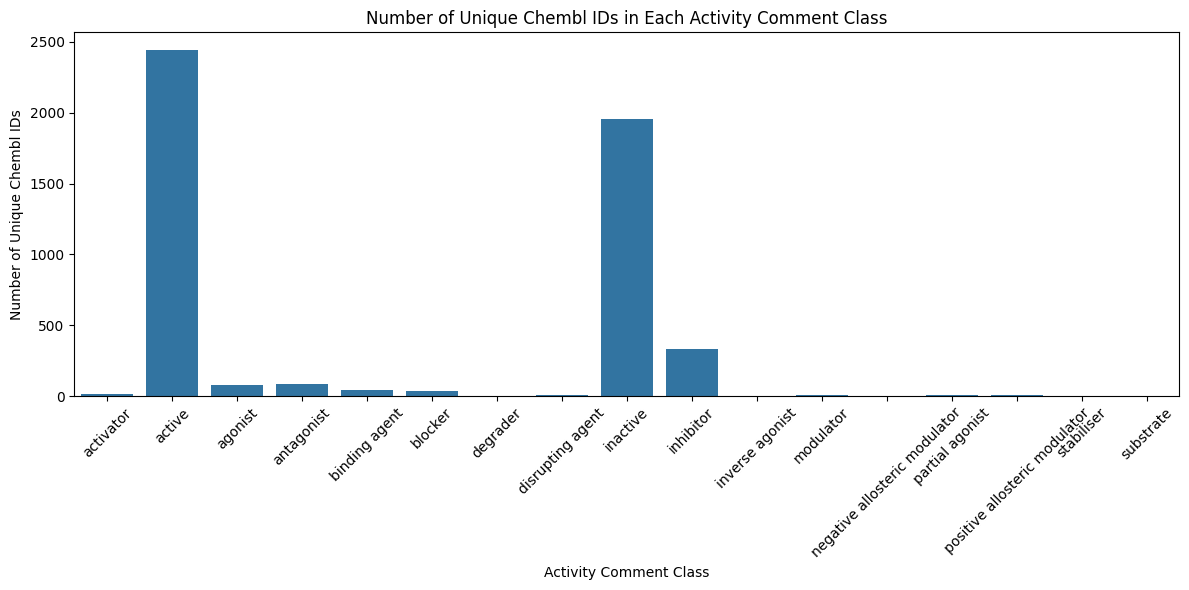

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'activity_comment_class' and get unique 'chembl_id's for each class
unique_chembl_counts = final_df.groupby('activity_comment_class')['parent_molecule_chembl_id'].nunique()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=unique_chembl_counts.index, y=unique_chembl_counts.values)
plt.title('Number of Unique Chembl IDs in Each Activity Comment Class')
plt.ylabel('Number of Unique Chembl IDs')
plt.xlabel('Activity Comment Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [49]:
for gene in final_df.gene_symbol.unique():
    
    df = final_df[final_df['gene_symbol']==gene]
    print(df.activity_comment_class.value_counts())
    

activity_comment_class
inactive     1432
active        331
inhibitor      20
Name: count, dtype: int64
activity_comment_class
inactive     1395
active        365
inhibitor      33
Name: count, dtype: int64
activity_comment_class
inactive     1354
active        396
inhibitor       5
Name: count, dtype: int64
activity_comment_class
inactive     1138
active        519
inhibitor       3
Name: count, dtype: int64
activity_comment_class
inactive     1410
active        418
inhibitor      21
Name: count, dtype: int64
activity_comment_class
inactive           842
active             139
antagonist           4
partial agonist      1
Name: count, dtype: int64
activity_comment_class
inactive     909
active        94
inhibitor      2
Name: count, dtype: int64
activity_comment_class
inactive         842
active           196
inhibitor          7
binding agent      5
Name: count, dtype: int64
activity_comment_class
inactive         891
active           152
antagonist         1
binding agent      1
Name

In [50]:
final_df.parent_molecule_chembl_id.value_counts()[:25]

parent_molecule_chembl_id
CHEMBL20         1327
CHEMBL54          542
CHEMBL42          536
CHEMBL118         459
CHEMBL135         432
CHEMBL6           374
CHEMBL6966        363
CHEMBL85          357
CHEMBL941         353
CHEMBL1276308     344
CHEMBL160         319
CHEMBL45          319
CHEMBL10          307
CHEMBL81          303
CHEMBL659         299
CHEMBL19019       298
CHEMBL98350       298
CHEMBL131         285
CHEMBL71          284
CHEMBL41          282
CHEMBL103         277
CHEMBL192         274
CHEMBL384467      274
CHEMBL2           274
CHEMBL44          273
Name: count, dtype: int64

In [51]:
final_df.activity_comment.value_counts()

activity_comment
Not Active (inhibition < 50% @ 10 uM and thus dose-reponse curve not measured)                                                   61700
Summarised AC50 (mean value for measurements with a relation sign "="; largest value for measurements with relation sign ">")     5004
inactive                                                                                                                          3161
Active                                                                                                                            3099
active                                                                                                                             822
                                                                                                                                 ...  
inhibitor [IC50=56.8uM]                                                                                                              1
inhibitor [IC50=46uM]                 

<Axes: >

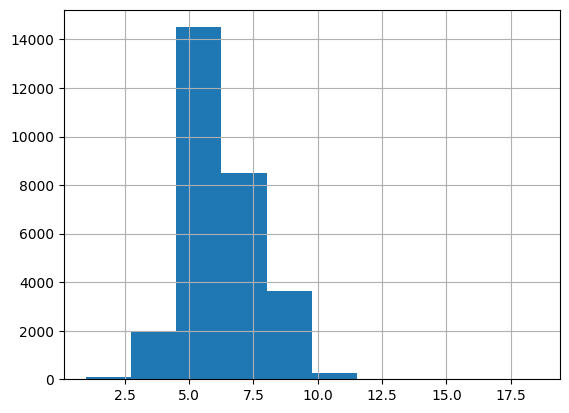

In [52]:
final_df.pchembl_value.hist()

In [53]:
final_df.gene_symbol.value_counts()

gene_symbol
CYP2D6     1849
CYP3A4     1793
CYP2C9     1783
CYP2C19    1755
CYP1A2     1660
           ... 
PHGDH         1
GSDMD         1
KDM5A         1
PDE4          1
PTGDR         1
Name: count, Length: 1038, dtype: int64

In [54]:
final_df.standard_type.value_counts()

standard_type
IC50    42789
Ki      38991
AC50    10253
EC50     2036
GI50       35
Name: count, dtype: int64

In [55]:
final_df.standard_units.value_counts()

standard_units
nM    28998
Name: count, dtype: int64